In [43]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import hdbscan # type: ignore
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.metrics import adjusted_rand_score, classification_report
from sklearn.preprocessing import LabelEncoder


In [44]:
df = pd.read_csv("processed/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv")

C:\Users\shaya\AppData\Local\Temp\ipykernel_9356\720906785.py:1: DtypeWarning: Columns (0,1,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("processed/Friday-16-02-2018_TrafficForML_CICFlowMeter.csv")


In [45]:
df.head()

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,16/02/2018 08:27:23,112640768,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,138.592929,56300000,56300000,Benign
1,0,0,16/02/2018 08:30:12,112641773,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,263.750829,56300000,56300000,Benign
2,35605,6,16/02/2018 08:26:55,20784143,23,44,2416,1344,240,64,...,20,2624734,0.0,2624734,2624734,9058214.0,0.0,9058214,9058214,Benign
3,0,0,16/02/2018 08:33:01,112640836,3,0,0,0,0,0,...,0,0,0.0,0,0,56300000.0,82.024387,56300000,56300000,Benign
4,23,6,16/02/2018 08:27:59,20,1,1,0,0,0,0,...,20,0,0.0,0,0,0.0,0.0,0,0,Benign


In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   Dst Port           1048575 non-null  object
 1   Protocol           1048575 non-null  object
 2   Timestamp          1048575 non-null  object
 3   Flow Duration      1048575 non-null  object
 4   Tot Fwd Pkts       1048575 non-null  object
 5   Tot Bwd Pkts       1048575 non-null  object
 6   TotLen Fwd Pkts    1048575 non-null  object
 7   TotLen Bwd Pkts    1048575 non-null  object
 8   Fwd Pkt Len Max    1048575 non-null  object
 9   Fwd Pkt Len Min    1048575 non-null  object
 10  Fwd Pkt Len Mean   1048575 non-null  object
 11  Fwd Pkt Len Std    1048575 non-null  object
 12  Bwd Pkt Len Max    1048575 non-null  object
 13  Bwd Pkt Len Min    1048575 non-null  object
 14  Bwd Pkt Len Mean   1048575 non-null  object
 15  Bwd Pkt Len Std    1048575 non-null  object
 16  

In [47]:
df = df[df["Label"] != "Label"]

In [48]:
df = df.drop(['Dst Port', 'Protocol', 'Timestamp'], axis=1)
df_y = df['Label'].copy() # Extract the Label column
df_x = df.drop('Label', axis=1).copy() # Extract all other columns as features
df_y_binary = df_y.apply(lambda x: 0 if x == 'Benign' else 1)

In [49]:
# Convert features to numeric
for col in df_x.columns:
    df_x[col] = pd.to_numeric(df_x[col], errors='coerce')

In [50]:
df_y.value_counts()

Label
DoS attacks-Hulk            461912
Benign                      446772
DoS attacks-SlowHTTPTest    139890
Name: count, dtype: int64

In [51]:
df_x.replace([np.inf, -np.inf], np.nan, inplace=True)
for column in df_x.columns:
    if df_x[column].isnull().any():
        df_x[column].fillna(df_x[column].mean(), inplace=True)


In [52]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_x)

In [53]:
pca = PCA(n_components=0.95) # Retain 95% of variance
X_pca = pca.fit_transform(X_scaled)
print(f"Number of PCA components: {X_pca.shape[1]}")

Number of PCA components: 13


In [54]:
# Initialize HDBSCAN
cluster = hdbscan.HDBSCAN(
    min_cluster_size=50,      # Minimum size of a cluster
    min_samples=10,           # Controls sensitivity to noise
    metric='manhattan'        
)
# Fit the model
cluster_labels = cluster.fit_predict(X_pca)  

# Print summary
print("Number of clusters found:", len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0))
print("Number of noise points:", (cluster_labels == -1).sum())

Number of clusters found: 1459
Number of noise points: 48052


In [ ]:
# Map predicted labels for ARI:601802
if -1 in cluster_labels and len(set(cluster_labels)) > 1: 
    most_common_cluster = Counter(cluster_labels[cluster_labels != -1]).most_common(1)[0][0]
else: # Handle cases where all are noise or only one cluster
    most_common_cluster = cluster_labels[0] if len(cluster_labels) > 0 else 0 

y_pred_binary = np.array([0 if label == most_common_cluster else 1 for label in cluster_labels])
ari = adjusted_rand_score(df_y_binary, y_pred_binary)
print(f"Adjusted Rand Index (Anomaly Mapping): {ari}")
# Classification report
print(classification_report(df_y_binary, y_pred_binary, target_names=['Normal', 'Anomaly']))

Adjusted Rand Index (Anomaly Mapping): 0.5014439937445507
              precision    recall  f1-score   support

      Normal       1.00      0.66      0.79    446772
     Anomaly       0.80      1.00      0.89    601802

    accuracy                           0.85   1048574
   macro avg       0.90      0.83      0.84   1048574
weighted avg       0.88      0.85      0.85   1048574



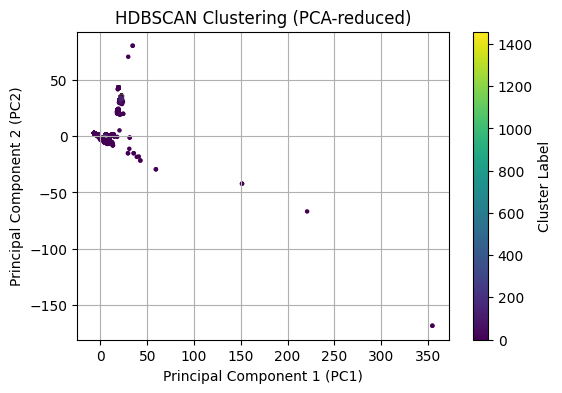

In [62]:
# Visualize PCA
plt.figure(figsize=(6, 4))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, c=cluster_labels, cmap='viridis')
plt.title('HDBSCAN Clustering (PCA-reduced)')
plt.xlabel('Principal Component 1 (PC1)')
plt.ylabel('Principal Component 2 (PC2)')
plt.colorbar(label='Cluster Label')
plt.grid(True)
plt.show()